In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import collections
import re
import nltk
from sklearn.model_selection import train_test_split
import scipy
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
from surprise import Reader, Dataset
from collections import defaultdict
from surprise import SVD, NMF, model_selection, accuracy,BaselineOnly,SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
warnings.filterwarnings('ignore')
sns.set_style('dark')

# Data Loading

In [2]:
movie = pd.read_table("movies.dat",sep='::',names=['movieid','movie','genre'])
print("Shape: ", movie.shape)
print(movie.isna().sum())
movie.head()

Shape:  (10681, 3)
movieid    0
movie      0
genre      0
dtype: int64


,movieid,movie,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings = pd.read_table("ratings.dat",sep='::',names=["userid","movieid","rating","timestamp"])
print("Shape: ", ratings.shape)
print(ratings.isna().sum())
ratings.head()

Shape:  (10000054, 4)
userid       0
movieid      0
rating       0
timestamp    0
dtype: int64


,userid,movieid,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [4]:
tags = pd.read_table("tags.dat",names=["userid","movieid","tag","timestamp"],sep='::')
print("Shape: ", tags.shape)
print(tags.isna().sum())
tags.head()

Shape:  (95580, 4)
userid        0
movieid       0
tag          16
timestamp     0
dtype: int64


,userid,movieid,tag,timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835


In [5]:
movie.describe().T

,count,mean,std,min,25%,50%,75%,max
movieid,10681.0,13120.523546,17808.849139,1.0,2755.0,5436.0,8713.0,65133.0


In [6]:
tags.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,95580.0,3.396336e+04,2.091622e+04,1.500000e+01,1.676600e+04,3.117500e+04,5.137200e+04,7.155600e+04
movieid,95580.0,1.251105e+04,1.753497e+04,1.000000e+00,1.645000e+03,4.308000e+03,8.641000e+03,6.513000e+04
timestamp,95580.0,1.176687e+09,2.779340e+07,1.135313e+09,1.151067e+09,1.174660e+09,1.197917e+09,1.231129e+09


In [7]:
ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,10000054.0,3.586986e+04,2.058534e+04,1.0,18123.0,3.574050e+04,5.360800e+04,7.156700e+04
movieid,10000054.0,4.120291e+03,8.938402e+03,1.0,648.0,1.834000e+03,3.624000e+03,6.513300e+04
rating,10000054.0,3.512422e+00,1.060418e+00,0.5,3.0,4.000000e+00,4.000000e+00,5.000000e+00
timestamp,10000054.0,1.032606e+09,1.159640e+08,789652009.0,946765880.0,1.035476e+09,1.126749e+09,1.231132e+09


# EDA

## Movie Dataset

In [186]:
# Genre Analysis
split_bar = " ".join(movie.genre).split("|") # Splitting the data from '|'
split_genre = []
for s in range(len(split_bar)): # Splittinng the data at the space where there are two letters
    if (" " in " ".join(movie.genre).split("|")[s]):
        split_genre.append(split_bar[s].split(" "))
    else:
        split_genre.append(split_bar[s])

In [187]:
split_genre = nltk.flatten(split_genre) # Flattening the list from the nested

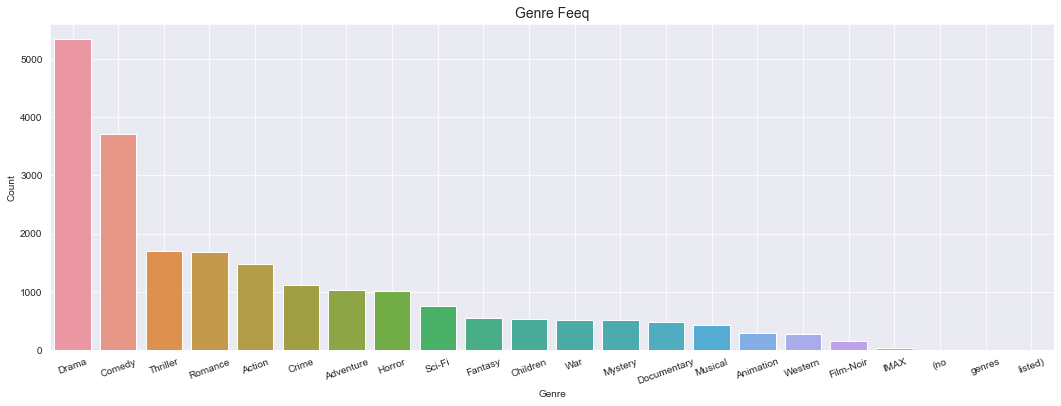

In [198]:
my_df = pd.DataFrame(dict(Counter(dict(Counter(split_genre))).most_common()).items())
fig, ax = plt.subplots(figsize=(18,6))
ax = sns.barplot(x=0, y=1, data=my_df)
ax.set(xlabel = 'Genre', ylabel='Count')
plt.title("Genre Feeq",size = 14)
plt.grid()
plt.xticks(rotation=20)
plt.show()

## Ratings

In [78]:
ratings.columns

Index(['userid', 'movieid', 'rating', 'timestamp'], dtype='object')

In [80]:
len(ratings.userid.unique())

69878

In [81]:
len(ratings.movieid.unique())

10677

In [82]:
len(ratings.rating.unique())

10

In [83]:
len(ratings.timestamp.unique())

7096905

In [84]:
ratings.shape

(10000054, 4)

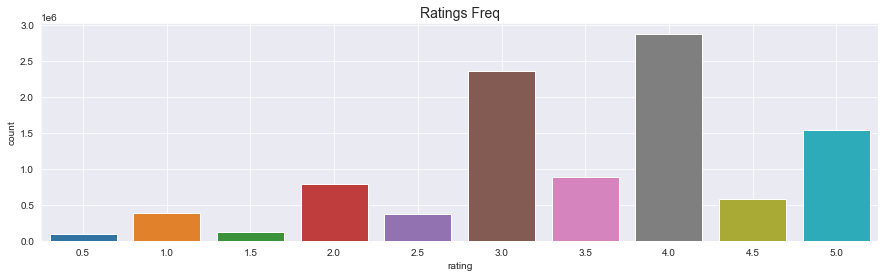

In [95]:
sns.set_style('dark')
fig, ax = plt.subplots(figsize=(15,4))
sns.countplot(ratings['rating'],ax = ax)
plt.title("Ratings Freq", size=14)
plt.grid()
plt.show()

## Tags

In [96]:
tags.columns

Index(['userid', 'movieid', 'tag', 'timestamp'], dtype='object')

In [199]:
ratings.columns

Index(['userid', 'movieid', 'rating', 'timestamp'], dtype='object')

In [208]:
movie.columns

Index(['movieid', 'movie', 'genre'], dtype='object')

In [209]:
data = pd.merge(ratings,movie,on =['movieid'],how='outer')
data.head()

,userid,movieid,rating,timestamp,movie,genre
0,1.0,122,5.0,8.389850e+08,Boomerang (1992),Comedy|Romance
1,139.0,122,3.0,9.743026e+08,Boomerang (1992),Comedy|Romance
2,149.0,122,2.5,1.112342e+09,Boomerang (1992),Comedy|Romance
3,182.0,122,3.0,9.434588e+08,Boomerang (1992),Comedy|Romance
4,215.0,122,4.5,1.102494e+09,Boomerang (1992),Comedy|Romance


In [210]:
data.isna().sum()

userid       4
movieid      0
rating       4
timestamp    4
movie        0
genre        0
dtype: int64

In [212]:
data.reset_index(drop=True)
data.to_pickle("data.pkl")

In [112]:
data.head()

,userid,movieid,rating,movie,genre
2,1751,4973,4.5,"Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le)...",Comedy|Romance
8,4335,4973,3.5,"Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le)...",Comedy|Romance
9,4650,4973,4.5,"Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le)...",Comedy|Romance
10,4650,4973,4.5,"Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le)...",Comedy|Romance
11,4650,4973,4.5,"Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le)...",Comedy|Romance


In [2]:
data = pd.read_pickle('data.pkl')

In [214]:
data[data.duplicated()]

,userid,movieid,rating,timestamp,movie,genre


## Merged data analysis

In [215]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",data.shape[0])
print("Total No of Users   :", len(np.unique(data.userid)))
print("Total No of movies  :", len(np.unique(data.movieid)))

Total data 
--------------------------------------------------

Total no of ratings : 10000058
Total No of Users   : 69882
Total No of movies  : 10681


In [216]:
# Movies rated
no_of_rated_movies_per_user = data.groupby(by='userid')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

userid
59269.0    7359
67385.0    7047
14463.0    5169
68259.0    4483
27468.0    4449
Name: rating, dtype: int64

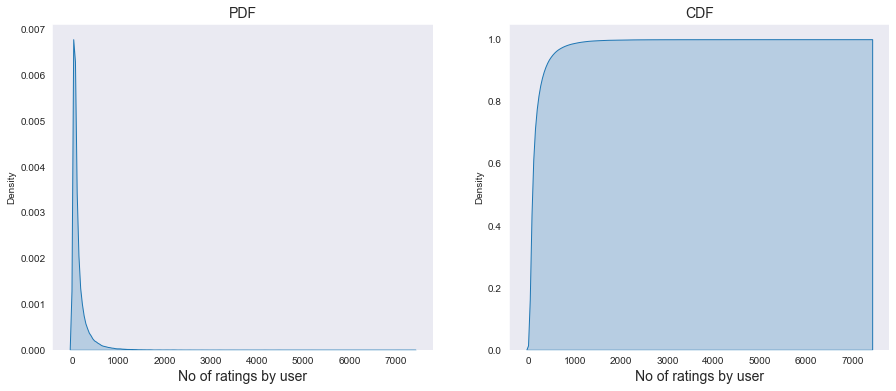

In [217]:
fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user',size = 14)
plt.title("PDF",size = 14)

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user',size = 14)
plt.title('CDF',size = 14)

plt.show()

In [220]:
no_of_rated_movies_per_user.describe()

count    69878.00000
mean       143.10733
std        216.71258
min         20.00000
25%         35.00000
50%         69.00000
75%        156.00000
max       7359.00000
Name: rating, dtype: float64

We could find that a very few number of users has actually rated most of the movies<br>
It could also be seen that there is a massive leap between 3rd and the 4th quantile

In [221]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01))

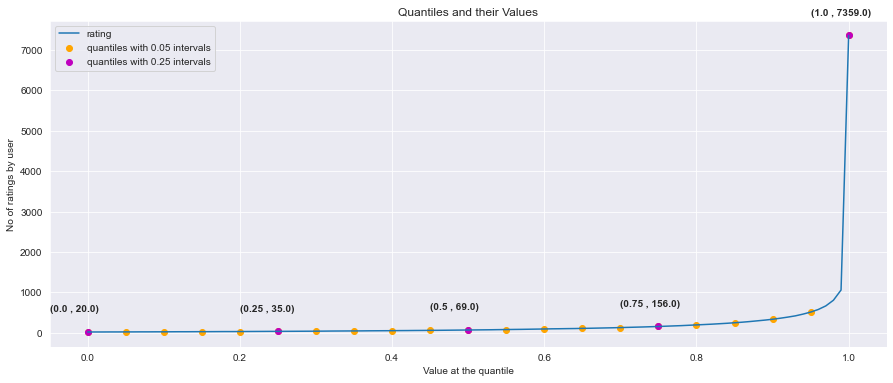

In [222]:
fig = plt.figure(figsize=(15,6))
plt.title("Quantiles and their Values")
quantiles.plot()
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')

plt.grid()
plt.show()

As we can see that, just between 0.9 and 1, there is a steep rise in rating

In [36]:
quantiles[::5]

0.00      20.0
0.05      22.0
0.10      24.0
0.15      28.0
0.20      31.0
0.25      35.0
0.30      40.0
0.35      46.0
0.40      52.0
0.45      60.0
0.50      69.0
0.55      80.0
0.60      94.0
0.65     109.0
0.70     129.0
0.75     156.0
0.80     195.0
0.85     248.0
0.90     335.0
0.95     512.0
1.00    7359.0
Name: rating, dtype: float64

In [223]:
print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 749)))


 No of ratings at last 5 percentile : 1634



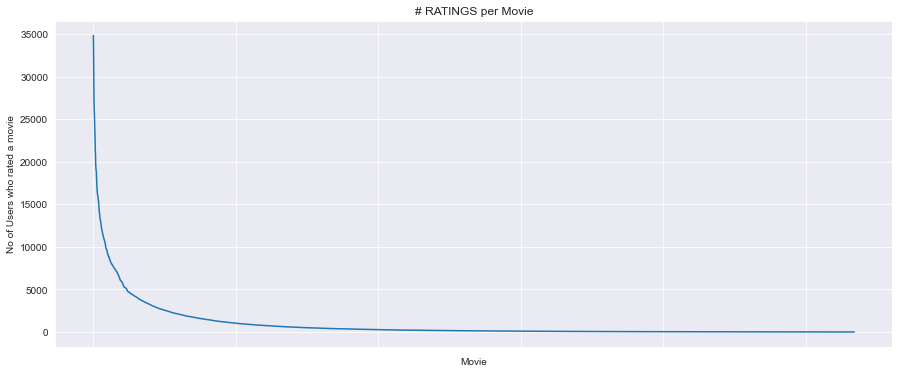

In [26]:
no_of_ratings_per_movie = data.groupby(by='movieid')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=(15,6))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])
plt.grid()
plt.show()

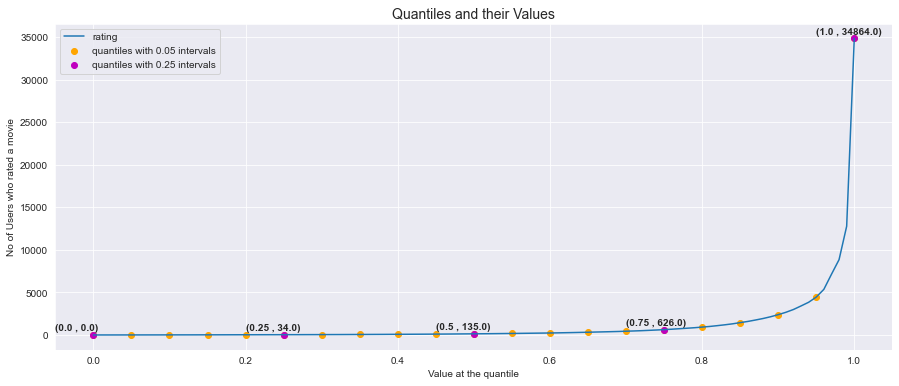

In [8]:
quantiles = no_of_ratings_per_movie.quantile(np.arange(0,1.01,0.01))

fig = plt.figure(figsize=(15,6))
quantiles.plot()
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of Users who rated a movie')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.title("Quantiles and their Values",size=14)
# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')

plt.grid()
plt.show()

## Splitting data and making sparse matrix

In [67]:
data.dropna(inplace=True)

In [68]:
train_df,test_df = train_test_split(data, test_size=0.30, random_state=42)

In [73]:
# Creating train sparse matrix
train_sparse_matrix = scipy.sparse.csr_matrix((train_df.rating.values,
                                               (train_df.userid.values.astype(int),
                                                train_df.movieid.values.astype(int)),))

In [74]:
# Saving the data
scipy.sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)

In [77]:
# Creating the test data
test_sparse_matrix = scipy.sparse.csr_matrix((test_df.rating.values, (test_df.userid.values.astype(int),
                                               test_df.movieid.values.astype(int))))

In [78]:
scipy.sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)

## Analysis

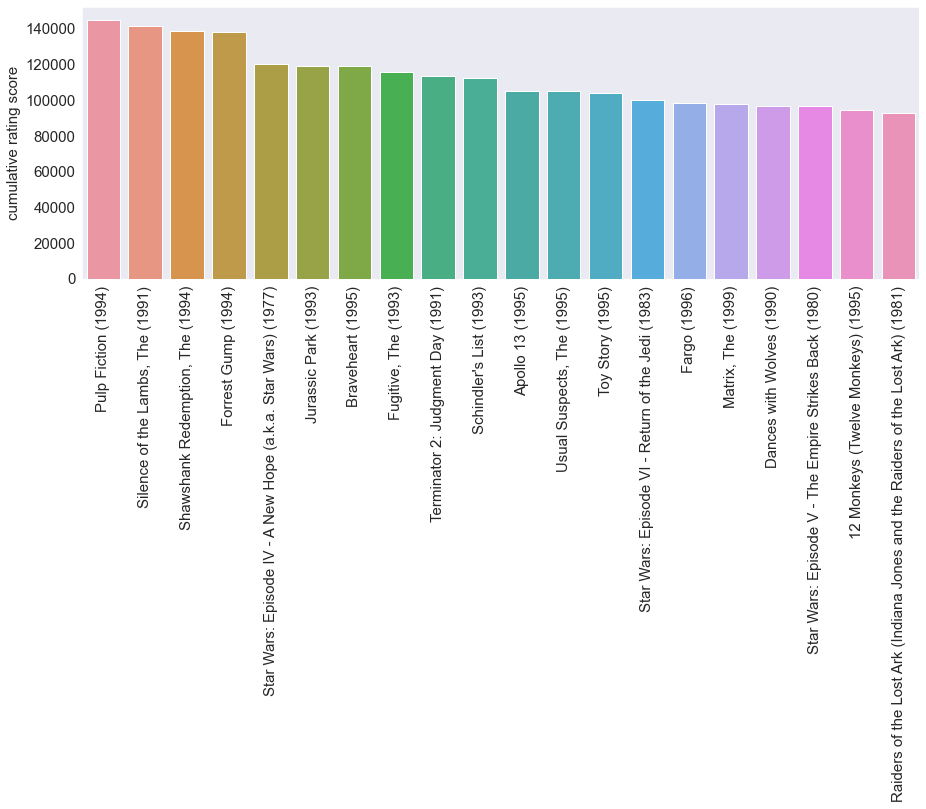

In [171]:
cm_rtg = data.groupby('movie').rating.sum()
cm_rtg = cm_rtg.sort_values(ascending=False)[:20]
idx = cm_rtg.index.tolist() # Get sorted book titles
vals = cm_rtg.values.tolist() # Get corresponding cm_rtg values

plt.figure(figsize=(15, 5))
sns.barplot(idx, vals)
plt.xticks(range(len(idx)), idx, rotation=90)
plt.ylabel('cumulative rating score')
plt.show()

In [127]:
cutoff = data.movie.value_counts()
mean_rtg = data[data.movie.isin(cutoff[cutoff>50].index)].groupby('movie')['rating'].mean()
mean_rtg.sort_values(ascending=False)[:10] # show only top 10

movie
Shawshank Redemption, The (1994)                 4.457238
Godfather, The (1972)                            4.415085
Usual Suspects, The (1995)                       4.367142
Schindler's List (1993)                          4.363483
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)    4.321966
Casablanca (1942)                                4.319741
Rear Window (1954)                               4.316544
Double Indemnity (1944)                          4.315439
Seven Samurai (Shichinin no samurai) (1954)      4.314119
Third Man, The (1949)                            4.313629
Name: rating, dtype: float64

In [128]:
mean_rtg.sort_values(ascending=False)[-10:] # Lowest Rated Movies

movie
Bratz: The Movie (2007)                                 1.269231
Faces of Death 6 (1996)                                 1.239362
Pokemon 4 Ever (a.k.a. PokÃ©mon 4: The Movie) (2002)    1.175966
Barney's Great Adventure (1998)                         1.175214
Gigli (2003)                                            1.174716
Glitter (2001)                                          1.167105
Carnosaur 3: Primal Species (1996)                      1.120253
PokÃ©mon Heroes (2003)                                  1.009615
From Justin to Kelly (2003)                             0.923611
SuperBabies: Baby Geniuses 2 (2004)                     0.803279
Name: rating, dtype: float64

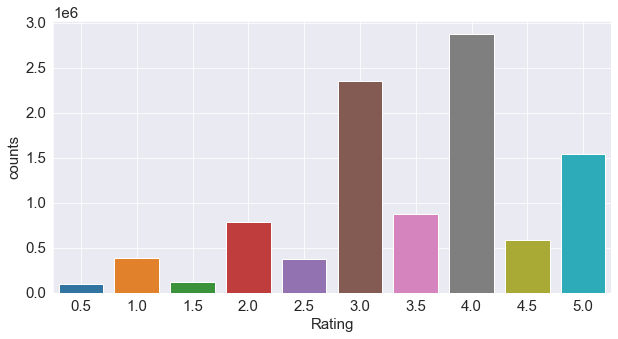

In [135]:
rtg = data.rating.value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.grid()
plt.show()

# Collaborative Filtering

In [2]:
train_sparse_matrix = scipy.sparse.load_npz("train_sparse_matrix.npz")
test_sparse_matrix = scipy.sparse.load_npz("test_sparse_matrix.npz")

In [3]:
# Due to lack of computation power reducing the data size
train_matrix_small = train_sparse_matrix[:10000, :10000]
test_matrix_small = test_sparse_matrix[:10000, :10000]

# Calculating cosine similarity between the items i.e movies
item_similarity = pairwise_distances(train_matrix_small.T, metric='cosine')

**Prediction:**<br>

<br>Every rating is multiplied by the similarity factor of the user who gave the rating. The final predicted rating by user U will be equal to the sum of the weighted ratings divided by the sum of the weights*

In [4]:
def predict(ratings, similarity):
    return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [42]:
item_prediction = predict(test_matrix_small, item_similarity)

In [43]:
def rmse(prediction, test_matrix):
    prediction = prediction[test_matrix.nonzero()].flatten()
    test_matrix = test_matrix[test_matrix.nonzero()].flatten().A1
    return sqrt(mean_squared_error(prediction, test_matrix))

print(f'Item-based CF RMSE: {rmse(item_prediction, test_matrix_small)}')

Item-based CF RMSE: 3.6357061296023954


**We see that the RootMeanSquareError for our CF model on item item similarity is ~3.635**

*Although we are getting a RMSE of ~3.63 (MSE: ~13.22), we would try with Matrix factorization technique*

# Matrix Factorization

We would use Surprise Library in making our model

In [2]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions]) # 'r_ui' gives the actual rating for the individual prediction
    pred = np.array([pred.est for pred in predictions]) # 'est' gives the estimate rating for the individual prediction
    return actual, pred

def get_errors(predictions):
# MAPE helps us in understanding how well is our model performing
    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual) # MAPE is the percentage of deviation from the actual prediction.
    return rmse, mape*100 

In [3]:
data = pd.read_pickle('data.pkl')
data.head()

,userid,movieid,rating,timestamp,movie,genre
0,1.0,122,5.0,8.389850e+08,Boomerang (1992),Comedy|Romance
1,139.0,122,3.0,9.743026e+08,Boomerang (1992),Comedy|Romance
2,149.0,122,2.5,1.112342e+09,Boomerang (1992),Comedy|Romance
3,182.0,122,3.0,9.434588e+08,Boomerang (1992),Comedy|Romance
4,215.0,122,4.5,1.102494e+09,Boomerang (1992),Comedy|Romance


## Overview with Cross Validation, with a small data

In [ ]:
train,test = train_test_split(data[['userid','movieid','rating']][:100000],test_size=0.30, random_state=42)

In [ ]:
# Building data to run in our SVD model
reader = Reader(rating_scale=(1, 10))
train = Dataset.load_from_df(train, reader)

In [83]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = model_selection.cross_validate(algorithm, train, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,0.981002,8.387692,3.341756
BaselineOnly,0.983619,0.095981,0.068442
KNNBasic,0.985636,9.413795,3.712410
SVDpp,0.987024,1.689994,0.059572
SVD,0.989732,0.984580,0.052671
KNNWithZScore,0.996766,11.737726,4.237967
KNNWithMeans,0.998636,15.023931,5.761219
SlopeOne,1.022262,0.149379,0.056338
NMF,1.028983,2.029819,0.047918


## BaselineOnly Model

$ \large {\hat{r}_{ui} = \mu + b_u + b_i} $


- $\pmb \mu $ : Global Average of all ratings
- $\pmb b_u$ : It is a user Bias, which is learned by optimization
- $\pmb b_i$ : It is a item Bias, which is learned by optimization

**Optimization**

$ \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$ 

In [97]:
train,test = train_test_split(data[['userid','movieid','rating']][:1000000],test_size=0.30, random_state=42)

In [98]:
# Building data to run in our BaselineOnly model
reader = Reader(rating_scale=(1, 10))
train = Dataset.load_from_df(train, reader)
train = train.build_full_trainset()
test = list(zip(test.userid.values, test.movieid.values, test.rating.values)) # Building testset as a user, movie, rating tuple

In [99]:
bsl_options = {'method': 'sgd',
               'learning_rate': .00005,
               }
model = BaselineOnly(bsl_options=bsl_options)

# Train the algorithm on the training set, and predict ratings for the test set
model.fit(train)
predictions = model.test(test)

# Then compute RMSE
accuracy.rmse(predictions)

Estimating biases using sgd...
RMSE: 0.9451


0.9450845116406147

In [100]:
# Checking accuracy
rsme,mape = get_errors(predictions)
print("BaselineOnly Model Details: ")
print("RSME: ", rsme)
print(f"MAPE: {mape} %")

BaselineOnly Model Details: 
RSME:  0.9450845116406147
MAPE: 30.550386070177883 %


## SVD Model

- $ \large  \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $

- $\pmb q_i$ - Item Rating Vector

- $\pmb p_u$ - User Rating Vector

**Optimization**

- $\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $

In [101]:
train,test = train_test_split(data[['userid','movieid','rating']][:1000000],test_size=0.30, random_state=42)

In [102]:
# Building data to run in our SVD model
reader = Reader(rating_scale=(1, 10))
train = Dataset.load_from_df(train, reader)
train = train.build_full_trainset()
test = list(zip(test.userid.values, test.movieid.values, test.rating.values)) # Building testset as a user, movie, rating tuple

In [103]:
model = SVD(n_factors=100, biased=True,verbose=True)

# Train the algorithm on the training set, and predict ratings for the test set
model.fit(train)
predictions = model.test(test)

# Then compute RMSE
accuracy.rmse(predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 0.8641


0.864146817608804

In [104]:
# Checking accuracy
rsme,mape = get_errors(predictions)
print("RSME: ", rsme)
print(f"MAPE: {mape} %")

RSME:  0.864146817608804
MAPE: 26.877594517709095 %


We can find a significance improvement in our model predictive power.<br>
From ~3.6 to ~0.86<br>
Also with more data, our model seems to be performing much better than our BaselineOnly Model

## KNNBaseline

\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}

- $\pmb{b_{ui}}$ -  _Baseline prediction_ of (user,movie) rating

- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  

- _sim (u, v)_ - The Similarity could be any as per our requirement and model performance

In [7]:
# Due to limitation in computation power I had to try KNNBaseline on a smaller dataset
# KNN is performing very well in our primary test, but due to lack of computational power, it could not be cultivated more
train,test = train_test_split(data[['userid','movieid','rating']][:40000],test_size=0.30, random_state=42)

In [8]:
# Building data to run in our KNNBaseline model
reader = Reader(rating_scale=(1, 10))
train = Dataset.load_from_df(train, reader)
train = train.build_full_trainset()
test = list(zip(test.userid.values, test.movieid.values, test.rating.values)) # Building testset as a user, movie, rating tuple

In [9]:
sim_options = {'user_based' : True,
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

model = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
# Train the algorithm on the training set, and predict ratings for the test set
model.fit(train)
predictions = model.test(test)

# RMSE
accuracy.rmse(predictions)

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0510


1.0509504218005863

In [10]:
# Checking accuracy
rsme,mape = get_errors(predictions)
print("RSME: ", rsme)
print(f"MAPE: {mape} %")

RSME:  1.0509504218005863
MAPE: 42.06229073714839 %


## SVDPP

- $ \large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
|I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right) $ 

- $ \pmb{I_u}$ --- the set of all items rated by user u

- $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings.  

- $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right) $ 

In [19]:
train,test = train_test_split(data[['userid','movieid','rating']][:1000000],test_size=0.30, random_state=42)

In [20]:
# Building data to run in our SVDPP model
reader = Reader(rating_scale=(1, 10))
train = Dataset.load_from_df(train, reader)
train = train.build_full_trainset()
test = list(zip(test.userid.values, test.movieid.values, test.rating.values)) # Building testset as a user, movie, rating tuple

In [21]:
# initiallize the model
model = SVDpp(n_factors=50, random_state=15, verbose=True)
model.fit(train)
predictions = model.test(test)

# Then compute RMSE
accuracy.rmse(predictions)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
RMSE: 0.8786


0.8785631281958621

In [22]:
# Checking accuracy
rsme,mape = get_errors(predictions)
print("RSME: ", rsme)
print(f"MAPE: {mape} %")

RSME:  0.8785631281958621
MAPE: 27.17927419607409 %


## NMF

$ \large  \hat r_{ui} = q_i^Tp_u $

**Biased Version**

$ \large  \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $

$\pmb q_i$ - Item Rating Vector
$\pmb p_u$ - User Rating Vector

In [23]:
# Due to limitation in computation power I had to try NMF on a smaller dataset
train,test = train_test_split(data[['userid','movieid','rating']][:1000000],test_size=0.30, random_state=42)

In [24]:
# Building data to run in our NMF model
reader = Reader(rating_scale=(1, 10))
train = Dataset.load_from_df(train, reader)
train = train.build_full_trainset()
test = list(zip(test.userid.values, test.movieid.values, test.rating.values)) # Building testset as a user, movie, rating tuple

In [25]:
model = NMF(n_factors=100, biased=True,verbose=True)

# Train the algorithm on the training set, and predict ratings for the test set
model.fit(train)
predictions = model.test(test)

# Then compute RMSE
accuracy.rmse(predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
RMSE: 1.01

1.0179379630811023

In [26]:
# Checking accuracy
rsme,mape = get_errors(predictions)
print("RSME: ", rsme)
print(f"MAPE: {mape} %")

RSME:  1.0179379630811023
MAPE: 30.549196921568246 %


The SVD is performing best with our dataset. Hence lets try to tune our SVD to see the results

In [27]:
train,test = train_test_split(data[['userid','movieid','rating']][:1000000],test_size=0.30, random_state=42)

In [28]:
# Building data to run in our SVD Hyperparameter model
reader = Reader(rating_scale=(1, 10))
train = Dataset.load_from_df(train, reader)

In [35]:
param_grid = {'n_factors': [80, 100, 120], 'lr_all': [0.001, 0.005, 0.01], 'reg_all': [0.01, 0.02, 0.04]}

# Optimize SVD algorithm for both root mean squared error ('rmse') and mean average error ('mae')
gs = model_selection.RandomizedSearchCV(SVD, param_grid, measures=['rmse', 'mae'], return_train_measures=True,joblib_verbose=100,n_jobs=5)

In [36]:
# Fit the gridsearch result on the entire dataset
gs.fit(train)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:   32.2s
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:   40.1s
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   48.8s
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:   57.7s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done  11 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  2.3min
[Parallel(

In [45]:
print("Best Param",gs.best_params['rmse'])
print("RSME Best Score",gs.best_score['rmse'])
print("MAE Best Score",gs.best_score['mae'])

Best Param {'n_factors': 120, 'lr_all': 0.01, 'reg_all': 0.04}
RSME Best Score 0.8870458724711889
MAE Best Score 0.696267700085528


*Lets train our model now on the whole training set*

In [46]:
# Prepairing Test Data
train = train.build_full_trainset()
test = list(zip(test.userid.values, test.movieid.values, test.rating.values)) # Building testset as a user, movie, rating tuple

In [50]:
model = SVD(n_factors= 120, lr_all= 0.01, reg_all= 0.04)
model.fit(train) # re-fit on only the training data using the best hyperparameters
test_pred = model.test(test)
print("SVD : Test Set")
# Checking accuracy
rsme,mape = get_errors(predictions)
print("RSME: ", rsme)
print(f"MAPE: {mape}")

SVD : Test Set
RSME:  1.0179379630811023
MAPE: 30.549196921568246


# Checking our model on real world data

In [52]:
train,test = train_test_split(data[['userid','movieid','rating']][:500000],test_size=0.30, random_state=42)

In [85]:
data.head()

,userid,movieid,rating,timestamp,movie,genre
0,1.0,122,5.0,8.389850e+08,Boomerang (1992),Comedy|Romance
1,139.0,122,3.0,9.743026e+08,Boomerang (1992),Comedy|Romance
2,149.0,122,2.5,1.112342e+09,Boomerang (1992),Comedy|Romance
3,182.0,122,3.0,9.434588e+08,Boomerang (1992),Comedy|Romance
4,215.0,122,4.5,1.102494e+09,Boomerang (1992),Comedy|Romance


In [79]:
# get a prediction for specific users and items.
uid = 65923.0  # the user_id int
iid = 466 # the movieid string
# This pair has an actual rating of 2.00!
pred = model.predict(uid, iid, verbose=True)

user: 65923.0    item: 466        r_ui = None   est = 2.77   {'was_impossible': False}


In [80]:
print(f'The estimated rating for the movie with the "movieid" code {pred.iid} from user #{pred.uid} is {pred.est:.2f}.\n')
actual_rtg = data[(data.userid==pred.uid) & (data.movieid==pred.iid)].rating.values[0]
print(f'The real rating given for this was {actual_rtg:.2f}.')
print('Movie Name: ',list(data[data.movieid==pred.iid]['movie'])[0])

The estimated rating for the movie with the "movieid" code 466 from user #65923.0 is 2.77.

The real rating given for this was 2.00.
Movie Name:  Hot Shots! Part Deux (1993)


In [81]:
# get a prediction for specific users and items.
uid = 9584.0  # the user_id int
iid = 364 # the movieid string
# This pair has an actual rating of 4.0!

pred = model.predict(uid, iid, verbose=True)

user: 9584.0     item: 364        r_ui = None   est = 4.42   {'was_impossible': False}


In [82]:
print(f'The estimated rating for the movie with the "movieid" code {pred.iid} from user #{pred.uid} is {pred.est:.2f}.\n')
actual_rtg = data[(data.userid==pred.uid) & (data.movieid==pred.iid)].rating.values[0]
print(f'The real rating given for this was {actual_rtg:.2f}.')
print('Movie Name: ',list(data[data.movieid==pred.iid]['movie'])[0])

The estimated rating for the movie with the "movieid" code 364 from user #9584.0 is 4.42.

The real rating given for this was 4.00.
Movie Name:  Lion King, The (1994)


We are getting ratings in the similar neighbourhood for the users.<br>
Hence we are able to capture the relationship in a much better way

In [97]:
# this function returns the top recommendations as per our model
def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions: # For each user we are mapping the item id and its predictive ratings
        top_n[uid].append((iid, est))

    # sorting the top items as per the value to 'n' provided.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

In [96]:
def get_recommendations(userid):
    movies_list = defaultdict(list)
    top_n = get_top_n(predictions, n=5) # Taking in the list of top 'n' recommendations
    for n in top_n[userid]: # For each user id retriving movie names from the movieid 
        movies, rating = n
        title = data.loc[data.movieid==movies].movie.unique()[0]
        movies_list[title] = rating
    return movies_list

In [120]:
# Just take a random look at user_id=2123.0 
example = get_recommendations(userid=2123.0)
for flicks, rating in example.items():
    print(f'{flicks}: {rating}')

Jurassic Park (1993): 4.539296470964872
Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977): 4.286019363047113
Terminator 2: Judgment Day (1991): 4.2312873497581185
Braveheart (1995): 4.094596753230709
Forrest Gump (1994): 4.0257881974427265


In [124]:
data[data.userid==2123.0][['movie','rating']]

,movie,rating
68,Boomerang (1992),2.0
2832,"Net, The (1995)",3.0
17879,Dumb & Dumber (1994),4.0
35678,Outbreak (1995),4.0
51842,Stargate (1994),3.0
...,...,...
9208254,Miami Rhapsody (1995),3.0
9316395,Bad Girls (1994),1.0
9339306,Stuart Saves His Family (1995),3.0
9408613,I Love Trouble (1994),2.0


In [114]:
# Just take a random look at user_id=53315.0
example = get_recommendations(userid=53315.0)
for flicks, rating in example.items():
    print(f'{flicks}: {rating}')

Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977): 3.908181989298681
Aladdin (1992): 3.560019166464716
Lion King, The (1994): 3.5299835276873313
Rock, The (1996): 3.4939522689369866
Speed (1994): 3.417517575457356


In [123]:
data[data.userid==53315.0][['movie','rating']]

,movie,rating
13639,"Net, The (1995)",4.0
30866,Dumb & Dumber (1994),3.5
47312,Outbreak (1995),3.0
65535,Stargate (1994),3.0
82408,Star Trek: Generations (1994),3.0
...,...,...
9999168,Jeremy (1973),2.5
9999516,Just Between Friends (1986),4.0
9999608,Conflict (1945),4.0
9999931,ThÃ©rÃ¨se (2004),3.5


The model is performing well in recommending user with movies which is rated higher.<br>
However the model would perform better if whole of the dataset could be used to in modeling.<br>
Given that the subset of our data is being used, the model is performing well in recommending movies to the user.